In [21]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Hide TensorFlow Warning due to using GPU
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
tf.random.set_seed(42)
import pathlib
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report

In [2]:
def plot_class_distribution(dataset_dir_path):
    # Directory path containing the image dataset
    dataset_dir = dataset_dir_path
    
    # Get the list of subdirectories (classes)
    classes = os.listdir(dataset_dir)
    
    # Initialize a dictionary to store the class names and image counts
    class_counts = {}
    
    # Iterate over the subdirectories
    for class_name in classes:
        # Get the path to the current class directory
        class_dir = os.path.join(dataset_dir, class_name)
        if os.path.isdir(class_dir):
            # Get the count of images in the class directory
            image_count = len(os.listdir(class_dir))
            class_counts[class_name] = image_count
    
    # Extract the class names and image counts for plotting
    class_names = list(class_counts.keys())
    image_counts = list(class_counts.values())
    
    # Create a bar plot
    plt.bar(class_names, image_counts)
    plt.xlabel("Classes")
    plt.ylabel("Number of Images")
    plt.title("Class Distribution")
    
    # Rotate the x-axis labels if needed
    plt.xticks(rotation=45)
    
    # Display the plot
    plt.show()

In [7]:
data_dir = "../dataset/Extended WaDaBa"
data_dir = pathlib.Path(data_dir) #pathlib.Path respect different semantics appropriate for different operating systems

In [8]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

4545


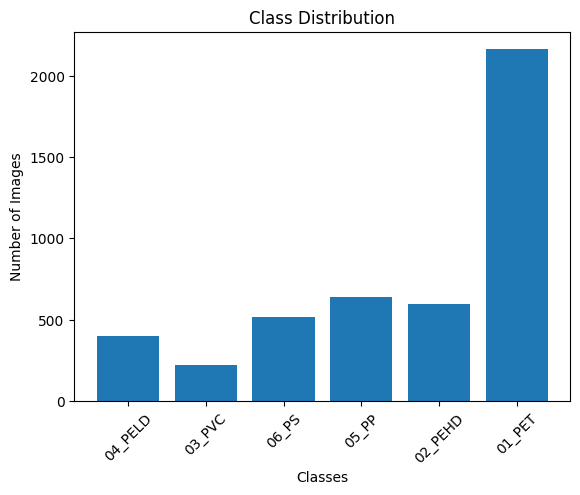

In [9]:
plot_class_distribution(data_dir)

In [10]:
batch_size = 32
img_height = 150
img_width = 150

In [11]:
ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

ds_size = tf.data.experimental.cardinality(ds).numpy()
print(ds_size)

Found 4545 files belonging to 6 classes.
143


In [12]:
class_names = ds.class_names
print(class_names)

['01_PET', '02_PEHD', '03_PVC', '04_PELD', '05_PP', '06_PS']


In [13]:
# Keras Apllications Pretrained Model Preprocessing
def preprocess(images, labels):
    return tf.keras.applications.mobilenet_v2.preprocess_input(images), labels
    # mobilenet_v2.preprocess_input will scale input pixels between -1 and 1.

# Apply preprocess
ds = ds.map(preprocess)

In [14]:
# Split dataset
def get_dataset_partitions_tf(ds, ds_size, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=15515):
    assert (train_split + test_split + val_split) == 1
    
    if shuffle:
        # Specify seed to always have the same split distribution between runs
        ds = ds.shuffle(shuffle_size, seed=123)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = get_dataset_partitions_tf(ds, ds_size, train_split=0.8, val_split=0.1, test_split=0.1)

In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [12]:
# Apply preprocess
train_ds = train_ds.map(preprocess)
val_ds = val_ds.map(preprocess)

In [15]:
num_classes = len(class_names)

# Load the pre-trained MobileNetV2 model without the top classification layer
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add a custom classification layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Create the transfer learning model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])

In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 75, 75, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 75, 75, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 75, 75, 32)   0           ['bn_Conv1[0][0]']           

In [17]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
114/114 [==============================] - 25s 109ms/step - loss: 0.5999 - accuracy: 0.7808 - val_loss: 0.3453 - val_accuracy: 0.8482
Epoch 2/10
114/114 [==============================] - 18s 101ms/step - loss: 0.3429 - accuracy: 0.8659 - val_loss: 0.2188 - val_accuracy: 0.9152
Epoch 3/10
114/114 [==============================] - 19s 101ms/step - loss: 0.2560 - accuracy: 0.8994 - val_loss: 0.1339 - val_accuracy: 0.9531
Epoch 4/10
114/114 [==============================] - 18s 100ms/step - loss: 0.1933 - accuracy: 0.9248 - val_loss: 0.1106 - val_accuracy: 0.9688
Epoch 5/10
114/114 [==============================] - 18s 100ms/step - loss: 0.1765 - accuracy: 0.9301 - val_loss: 0.1137 - val_accuracy: 0.9640
Epoch 6/10
114/114 [==============================] - 18s 100ms/step - loss: 0.1354 - accuracy: 0.9465 - val_loss: 0.0409 - val_accuracy: 0.9933
Epoch 7/10
114/114 [==============================] - 18s 101ms/step - loss: 0.1434 - accuracy: 0.9439 - val_loss: 0.0719 - val_ac

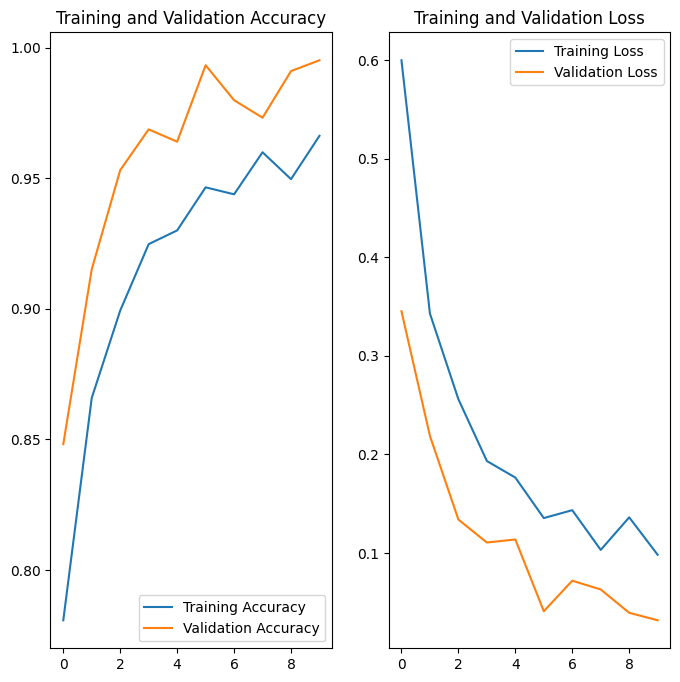

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [19]:
predictions = np.array([])
labels =  np.array([])
for x, y in test_ds:
  predictions = np.concatenate([predictions, np.argmax(model.predict(x), axis = -1)])
  labels = np.concatenate([labels, y.numpy()])

1/1 [==============================] - 0s 16ms/step


In [22]:
print(classification_report(labels, predictions))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       223
         1.0       1.00      0.99      0.99        67
         2.0       1.00      1.00      1.00        32
         3.0       1.00      1.00      1.00        45
         4.0       0.98      0.98      0.98        60
         5.0       0.96      0.98      0.97        53

    accuracy                           0.99       480
   macro avg       0.99      0.99      0.99       480
weighted avg       0.99      0.99      0.99       480



In [25]:
confusion_matrix = tf.math.confusion_matrix(labels=labels, predictions=predictions).numpy()
print(confusion_matrix)

[[223   0   0   0   0   0]
 [  0  66   0   0   0   1]
 [  0   0  32   0   0   0]
 [  0   0   0  45   0   0]
 [  0   0   0   0  59   1]
 [  0   0   0   0   1  52]]


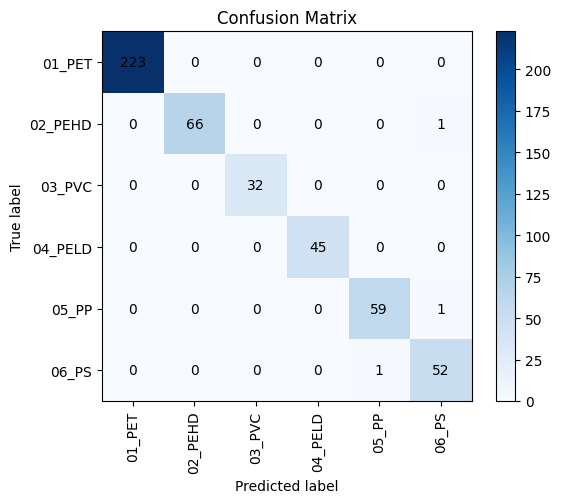

In [26]:
# Plot the confusion matrix
fig, ax = plt.subplots()
im = ax.imshow(confusion_matrix, cmap='Blues')

# Customize the plot
ax.set_xticks(np.arange(len(class_names)))
ax.set_yticks(np.arange(len(class_names)))
ax.set_xticklabels(class_names, rotation=90)  # Rotate x-axis labels vertically
ax.set_yticklabels(class_names)
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')
ax.set_title('Confusion Matrix')

# Add the value annotations to the plot
for i in range(len(class_names)):
    for j in range(len(class_names)):
        text = ax.text(j, i, confusion_matrix[i, j], ha='center', va='center', color='black')

# Display the colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# Show the plot
plt.show()

In [27]:
model_save_path = '../saved_models/Plastic Classifier/mobile_net_v2_wadaba.h5'
model.save(model_save_path)